In [1]:
!pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [14]:
import tensorflow as tf
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from tensorflow.data import TFRecordDataset


print("PyTorch version:", torch.__version__)
print("PyTorch/XLA version:", torch_xla.__version__)

PyTorch version: 2.4.0+cu121
PyTorch/XLA version: 2.4.0+libtpu


In [3]:
import os


# Список файлов в директории
print(os.listdir("/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"))

['val', 'test', 'train']


In [4]:
import numpy as np
from albumentations import (
    Blur,
    CoarseDropout,
    Compose,
    GaussNoise,
    HorizontalFlip,
    HueSaturationValue,
    Normalize,
    Resize,
    ShiftScaleRotate,
)
from albumentations.pytorch import ToTensorV2


def transform_image(image, is_train=True):
    image = image.numpy().astype(np.uint8)

    mean = [0.45397732, 0.42053542, 0.29964647]
    std = [0.24271463, 0.21145713, 0.21939221]

    if is_train:
        transforms = Compose(
            [
                Resize(*(224, 224, 3)),  # for mobilenetv4_hybrid_medium.e500_r224_in1k (train)
                HorizontalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(
                    hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5
                ),
                CoarseDropout(max_holes=3, max_height=32, max_width=32, p=0.25),
                Blur(blur_limit=3, p=0.25),
                GaussNoise(p=0.25),
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )
    else:
        transforms = Compose(
            [
                Resize(*(256, 256, 3)),  # for mobilenetv4_hybrid_medium.e500_r224_in1k (test)
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )

    transformed = transforms(image=image)
    return transformed["image"]


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = example["class"]
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    id_ = example["id"]
    return image, id_


def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    maped_dataset = dataset.map(
        read_labeled_tfrecord if labeled else read_unlabeled_tfrecord
    )  # a dataset of (image, label) pairs if labeled=True or (image, id) if labeled=False
    for elem in maped_dataset:
        yield elem


def load_tensor_batches(generator_dataset, batch_size=128, labeled=True, is_train=True):
    i = 0
    batch_imgs, batch_lbls = list(), list()
    for elem in generator_dataset:
        img = transform_image(image=elem[0], is_train=is_train).type(torch.float32)
        lbl = (
            torch.tensor(elem[1].numpy(), dtype=torch.float32)
            if labeled
            else elem[1].numpy().decode("utf-8")
        )
        batch_imgs.append(img)
        batch_lbls.append(lbl)
        i += 1
        if i % batch_size == 0:
            yield torch.stack(batch_imgs), torch.stack(batch_lbls) if labeled else batch_lbls
            batch_imgs, batch_lbls = list(), list()


def get_recursive_paths(path, mode="train"):
    list_filePath = list()
    for folder, subfolders, files in os.walk(os.path.join(path, mode)):
        for file in files:
            filePath = os.path.abspath(os.path.join(folder, file))
            if ".tfrec" in filePath.split("/")[-1]:
                list_filePath.append(filePath)
    return list_filePath

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"

train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

In [6]:
train_trf_dataset

<generator object load_dataset at 0x7c5e3851cd60>

In [7]:
import matplotlib.pyplot as plt


path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"
train_trf_dataset = load_dataset(get_recursive_paths(path, "test"), labeled=False)

batch_train_tensors = next(load_tensor_batches(train_trf_dataset, labeled=False, is_train=False))

In [8]:
batch_train_tensors[0].shape

torch.Size([128, 3, 256, 256])

fe737e3b1


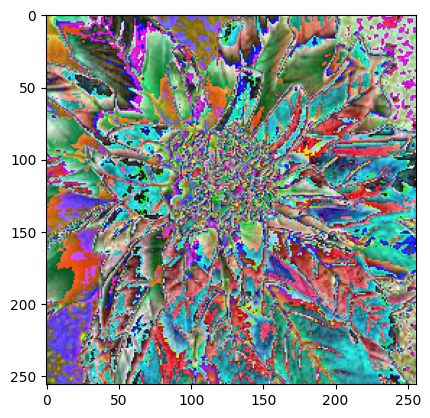

In [9]:
import random

import numpy as np


batch_imgs, batch_lbls = batch_train_tensors
batch_imgs_np = [(image.permute(1, 2, 0) * 255.0).numpy().astype(np.uint8) for image in batch_imgs]

rand_id = random.randrange(0, len(batch_imgs_np))
print(batch_lbls[rand_id])
plt.imshow(batch_imgs_np[rand_id])

In [10]:
!pip install wandb
!pip install lightning

import os

import wandb


os.environ["WANDB_API_KEY"] = "3f27a3afb5700e7542c1fa3e3f210399ca7a9fb0"

wandb.login()


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


wandb: Currently logged in as: alex-m-1 (projects_alexmak123). Use `wandb login --relogin` to force relogin


True

In [11]:
import matplotlib.pyplot as plt
import torch_xla.distributed.parallel_loader as pl
from torch.utils.data import DataLoader, Dataset


class CustomDataset(Dataset):
    def __init__(self, file_paths, mode="train", ordered=False):
        self.file_paths = file_paths
        self.mode = mode
        self.labeled = self.mode in [
            "train",
            "val",
        ]
        self.is_train = self.mode in [
            "train",
        ]
        self.tfr_dataset = tf.data.TFRecordDataset(self.file_paths)

        ignore_order = tf.data.Options()
        if not ordered:
            ignore_order.experimental_deterministic = False

        self.tfr_dataset = list(self.tfr_dataset.with_options(ignore_order))

    def __len__(self):
        return len(self.tfr_dataset)

    def __getitem__(self, idx):
        example = self.tfr_dataset[idx]
        image, label = (
            read_labeled_tfrecord(example) if self.labeled else read_unlabeled_tfrecord(example)
        )

        transformed_image = transform_image(image, is_train=self.is_train)

        if self.labeled:
            return transformed_image, torch.tensor(label.numpy(), dtype=torch.float32)
        else:
            return transformed_image, label.numpy().decode("utf-8")

In [12]:
import math
import os

import lightning
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.loggers import WandbLogger
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from tqdm import tqdm


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 104),
        )

    def forward(self, x):
        return self.model(x)


class LitModel(lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.loss_fn = nn.NLLLoss()
        self.lr = 5e-3
        self.activation = F.log_softmax

    def forward(self, x):
        return self.encoder(x)

    def training_step(self, train_batch, batch_idx):
        train_imgs, train_lbls = train_batch
        predict_probas = self.activation(self(train_imgs), dim=1)
        loss = self.loss_fn(predict_probas, train_lbls)
        train_f1_score = f1_score(
            train_lbls.detach().cpu().numpy(),
            torch.argmax(predict_probas, dim=1).detach().cpu().numpy(),
            average="macro",
        )

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_f1_score", train_f1_score, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, val_batch, batch_idx):
        val_imgs, val_lbls = val_batch
        predict_probas = self.activation(self(val_imgs), dim=1)
        loss = self.loss_fn(predict_probas, val_lbls)
        val_f1_score = f1_score(
            val_lbls.detach().cpu().numpy(),
            torch.argmax(predict_probas, dim=1).detach().cpu().numpy(),
            average="macro",
        )

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_f1_score", val_f1_score, on_step=True, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"},
        }

In [13]:
import random


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)


set_seed(42)

In [ ]:
from pytorch_lightning.loggers import WandbLogger


try:
    os.environ.pop("TPU_PROCESS_ADDRESSES")
except KeyError:
    print("already done")
try:
    os.environ.pop("CLOUD_TPU_TASK_ID")
except KeyError:
    print("already done")

num_epochs = 100
batch_size = 512
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"

custom_dataset_train = CustomDataset(file_paths=get_recursive_paths(path, "train"), mode="train")
custom_dataset_val = CustomDataset(file_paths=get_recursive_paths(path, "val"), mode="val")

train_dataloader = DataLoader(
    custom_dataset_train, batch_size=batch_size, shuffle=True, num_workers=8
)
val_dataloader = DataLoader(custom_dataset_val, batch_size=batch_size, shuffle=True, num_workers=8)

wandb.finish()

xlm_model = LitModel()
logger = WandbLogger(project="kaggle_top11", log_model="all")

trainer = lightning.Trainer(logger=logger, max_epochs=num_epochs, accelerator="tpu")

trainer.fit(xlm_model, train_dataloader, val_dataloader)

already done
already done


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: True, using: 8 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/site-packages/lightning/pytorch/strategies/xla.py:242: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/strat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/site-packages/torch_xla/core/xla_model.py:1383: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se

/usr/local/lib/python3.10/site-packages/torch_xla/core/xla_model.py:1383: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xldata.append(torch.load(xbio))
/usr/local/lib/python

Epoch 0: 100%|██████████| 4/4 [01:32<00:00,  0.04it/s, v_num=niy5, train_loss_step=4.100, train_f1_score_step=0.0242]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [01:47<00:00,  0.04it/s, v_num=niy5, train_loss_step=4.100, train_f1_score_step=0.0242, val_loss_step=17.00, val_f1_score_step=0.0079, val_loss_epoch=17.00, val_f1_score_epoch=0.0079, train_loss_epoch=4.510, train_f1_score_epoch=0.00908]

/usr/local/lib/python3.10/site-packages/lightning/pytorch/strategies/xla.py:242: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/strat

Epoch 1: 100%|██████████| 4/4 [00:09<00:00,  0.42it/s, v_num=niy5, train_loss_step=3.760, train_f1_score_step=0.0428, val_loss_step=17.00, val_f1_score_step=0.0079, val_loss_epoch=17.00, val_f1_score_epoch=0.0079, train_loss_epoch=4.510, train_f1_score_epoch=0.00908]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:17<00:00,  0.23it/s, v_num=niy5, train_loss_step=3.760, train_f1_score_step=0.0428, val_loss_step=10.20, val_f1_score_step=0.00333, val_loss_epoch=10.20, val_f1_score_epoch=0.00333, train_loss_epoch=3.940, train_f1_score_epoch=0.0164] 

/usr/local/lib/python3.10/site-packages/lightning/pytorch/strategies/xla.py:242: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/strat

Epoch 2: 100%|██████████| 4/4 [00:09<00:00,  0.40it/s, v_num=niy5, train_loss_step=3.730, train_f1_score_step=0.0638, val_loss_step=10.20, val_f1_score_step=0.00333, val_loss_epoch=10.20, val_f1_score_epoch=0.00333, train_loss_epoch=3.940, train_f1_score_epoch=0.0164]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:17<00:00,  0.23it/s, v_num=niy5, train_loss_step=3.730, train_f1_score_step=0.0638, val_loss_step=6.490, val_f1_score_step=0.0112, val_loss_epoch=6.490, val_f1_score_epoch=0.0112, train_loss_epoch=3.760, train_f1_score_epoch=0.0187]  

/usr/local/lib/python3.10/site-packages/lightning/pytorch/strategies/xla.py:242: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/strat

Epoch 3: 100%|██████████| 4/4 [00:09<00:00,  0.42it/s, v_num=niy5, train_loss_step=3.700, train_f1_score_step=0.0229, val_loss_step=6.490, val_f1_score_step=0.0112, val_loss_epoch=6.490, val_f1_score_epoch=0.0112, train_loss_epoch=3.760, train_f1_score_epoch=0.0187]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:16<00:00,  0.24it/s, v_num=niy5, train_loss_step=3.700, train_f1_score_step=0.0229, val_loss_step=5.200, val_f1_score_step=0.00801, val_loss_epoch=5.200, val_f1_score_epoch=0.00801, train_loss_epoch=3.650, train_f1_score_epoch=0.0253]

/usr/local/lib/python3.10/site-packages/lightning/pytorch/strategies/xla.py:242: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/strat

Epoch 4: 100%|██████████| 4/4 [00:09<00:00,  0.42it/s, v_num=niy5, train_loss_step=3.370, train_f1_score_step=0.0476, val_loss_step=5.200, val_f1_score_step=0.00801, val_loss_epoch=5.200, val_f1_score_epoch=0.00801, train_loss_epoch=3.650, train_f1_score_epoch=0.0253]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:16<00:00,  0.24it/s, v_num=niy5, train_loss_step=3.370, train_f1_score_step=0.0476, val_loss_step=4.280, val_f1_score_step=0.010, val_loss_epoch=4.280, val_f1_score_epoch=0.010, train_loss_epoch=3.530, train_f1_score_epoch=0.025]     

/usr/local/lib/python3.10/site-packages/lightning/pytorch/strategies/xla.py:242: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/strat

Epoch 5: 100%|██████████| 4/4 [00:08<00:00,  0.46it/s, v_num=niy5, train_loss_step=3.770, train_f1_score_step=0.044, val_loss_step=4.280, val_f1_score_step=0.010, val_loss_epoch=4.280, val_f1_score_epoch=0.010, train_loss_epoch=3.530, train_f1_score_epoch=0.025] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:16<00:00,  0.25it/s, v_num=niy5, train_loss_step=3.770, train_f1_score_step=0.044, val_loss_step=4.040, val_f1_score_step=0.0208, val_loss_epoch=4.040, val_f1_score_epoch=0.0208, train_loss_epoch=3.480, train_f1_score_epoch=0.0372]

/usr/local/lib/python3.10/site-packages/lightning/pytorch/strategies/xla.py:242: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/strat

Epoch 6: 100%|██████████| 4/4 [00:09<00:00,  0.40it/s, v_num=niy5, train_loss_step=3.350, train_f1_score_step=0.0615, val_loss_step=4.040, val_f1_score_step=0.0208, val_loss_epoch=4.040, val_f1_score_epoch=0.0208, train_loss_epoch=3.480, train_f1_score_epoch=0.0372]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:17<00:00,  0.23it/s, v_num=niy5, train_loss_step=3.350, train_f1_score_step=0.0615, val_loss_step=3.690, val_f1_score_step=0.0315, val_loss_epoch=3.690, val_f1_score_epoch=0.0315, train_loss_epoch=3.400, train_f1_score_epoch=0.0343]

/usr/local/lib/python3.10/site-packages/lightning/pytorch/strategies/xla.py:242: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/strat

Epoch 7:   0%|          | 0/4 [00:00<?, ?it/s, v_num=niy5, train_loss_step=3.350, train_f1_score_step=0.0615, val_loss_step=3.690, val_f1_score_step=0.0315, val_loss_epoch=3.690, val_f1_score_epoch=0.0315, train_loss_epoch=3.400, train_f1_score_epoch=0.0343]        

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(train_losses), label="Train Loss")
plt.plot(list(val_losses), label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from collections import defaultdict


xlm_model.eval()
test_data = next(
    load_tensor_batches(
        load_dataset(get_recursive_paths(path, "test"), labeled=False),
        batch_size=1,
        labeled=False,
        is_train=False,
    )
)

test_imgs, test_filename = test_data[0].to(device, dtype=torch.float32), test_data[1]
lbls_predict = xlm_model(test_imgs)

print(int(torch.argmax(lbls_predict, dim=1).detach().cpu().squeeze()), test_filename)

In [ ]:
from collections import defaultdict

import pandas as pd


xlm_model.eval()
test_data = load_tensor_batches(
    load_dataset(get_recursive_paths(path, "test"), labeled=False), batch_size=1, labeled=False
)
test_dataframe = defaultdict(list)

for i, test_batch in enumerate(test_data):
    test_imgs, test_filename = test_batch[0].to(device, dtype=torch.float32), test_batch[1]
    lbls_predict = xlm_model(test_imgs)
    test_dataframe["id"].append(*test_filename)
    test_dataframe["label"].append(int(torch.argmax(lbls_predict, dim=1).detach().cpu().squeeze()))

In [ ]:
solution = pd.DataFrame(test_dataframe).reset_index(drop=True)

In [ ]:
solution.head(5)

In [ ]:
solution.to_csv(f"conv_baseline_solution.csv", index=False)